# Baseline

This notebook runs a baseline using bert-multilingual-cased and a simple neural network.

## Setup and Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import json
from pathlib import Path

import pytorch_lightning as pl
import torch
from pytorch_lightning import callbacks, seed_everything
from torch import nn

from nlp_assemblee.simple_datasets import AssembleeDataset
from nlp_assemblee.simple_trainer import LitModel, load_embedding, process_predictions
from nlp_assemblee.simple_visualisation import (
    calculate_metrics,
    plot_confusion_matrix,
    plot_network_graph,
    plot_precision_recall_curve,
    plot_roc_curve,
)

In [3]:
seed_everything(42, workers=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

Global seed set to 42


'cuda'

## Definition of the notebook variables

In [4]:
# To change between experiments
FEATURES = True
TEXT_VARS = ["intervention", "titre_regexed", "contexte"]

BATCH_SIZE = 128
MAX_EPOCHS = 100

CALLBACKS = [
    callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0.005,
        check_finite=True,
        patience=10,
        verbose=True,
    ),
    callbacks.ModelSummary(max_depth=-1),
    callbacks.Timer(duration="00:03:00:00", interval="epoch"),
    callbacks.RichProgressBar(
        theme=callbacks.progress.rich_progress.RichProgressBarTheme(
            description="green_yellow", progress_bar="green1"
        )
    ),
    callbacks.LearningRateMonitor(logging_interval="epoch", log_momentum=False),
    callbacks.ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        verbose=True,
        save_last=True,
    ),
]

OPTIMIZER_TYPE = "Adam"
OPTIMIZER_KWARGS = {}
LR = 1e-4
LOSS = "CrossEntropyLoss"

SCHEDULER_KWARGS = {
    "scheduler": "ReduceLROnPlateau",
    "mode": "min",
    "factor": 0.1,
    "patience": 3,
    "interval": "epoch",
    "frequency": 1,
    "strict": True,
    "monitor": "val_loss",
}
# SCHEDULER_KWARGS = {
#     "scheduler": "OneCycleLR",
#     "max_lr": 5e-3,
#     "pct_start": 0.3,
#     "epochs": 30,
#     "steps_per_epoch": 100,
#     "interval": "epoch",
#     "frequency": 1,
#     "strict": True
# }


# Doesn't change between experiments
LABEL_VAR = "label"
DATA_ROOT = "../../data/"
NUM_WORKERS = 12
PREFETCH_FACTOR = 4
PIN_MEMORY = True
ACCELERATOR = "gpu"
DEVICE = "cuda"
LOG_EVERY_N_STEPS = 50
CHECK_VAL_EVERY_N_EPOCH = 1
DETERMINISTIC = False

/tmp/ipykernel_26090/1117188679.py:20: UnderReviewWarning: The feature PrintTableMetricsCallback is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  PrintTableMetricsCallback(),


## First Experiment

In [5]:
MODEL_NAME = "bert-base-multilingual-cased"
MODEL_FOLDER = f"../../data/precomputed/{MODEL_NAME}"
RESULTS_PATH = f"../../results/{MODEL_NAME}/"
LOGGER = pl.loggers.TensorBoardLogger(RESULTS_PATH, log_graph=False)
Path(RESULTS_PATH).mkdir(parents=True, exist_ok=True)

### Definition of the net architecture

In [6]:
class Net(nn.Module):
    def __init__(self, root, embed_dim, inter_dim, dropout=0.2, freeze=True):
        super().__init__()
        self.example_input_array = {
            "text": {
                "intervention": torch.randn(32, 768),
                "titre_regexed": torch.randint(100, (32,)).int(),
                "contexte": torch.randint(100, (32,)).int(),
            }
        }

        self.embed_dim = embed_dim
        self.inter_dim = inter_dim
        self.dropout = dropout
        self.freeze = freeze

        self.titre_embeddings = load_embedding(root, "titre_regexed", freeze=freeze)
        self.titre_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.ReLU(),
        )

        self.contexte_embeddings = load_embedding(root, "contexte", freeze=freeze)
        self.contexte_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.ReLU(),
        )

        self.intervention_fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(embed_dim, inter_dim),
            nn.ReLU(),
        )

        self.mlp = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(inter_dim, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 3),
        )

    def forward(self, **x):
        intervention = x["text"]["intervention"]
        titre_regexed = x["text"]["titre_regexed"]
        contexte = x["text"]["contexte"]

        intervention_repr = self.intervention_fc(intervention)

        titre_emb = self.titre_embeddings(titre_regexed)
        titre_repr = self.titre_fc(titre_emb)

        contexte_emb = self.contexte_embeddings(contexte)
        contexte_repr = self.contexte_fc(contexte_emb)

        pooled_repr = intervention_repr + titre_repr + contexte_repr

        logits = self.mlp(pooled_repr)

        return logits

In [7]:
NET = Net(MODEL_FOLDER, 768, 1024, dropout=0.2, freeze=True)

### Definition of the trainer and module

In [8]:
lit_model = LitModel(
    NET,
    optimizer_type=OPTIMIZER_TYPE,
    learning_rate=LR,
    optimizer_kwargs=OPTIMIZER_KWARGS,
    scheduler_kwargs=SCHEDULER_KWARGS,
    criterion_type=LOSS,
    batch_size=BATCH_SIZE,
    loader_kwargs={
        "root": MODEL_FOLDER,
        "text_vars": TEXT_VARS,
        "use_features": FEATURES,
        "label_var": LABEL_VAR,
        "num_workers": NUM_WORKERS,
        "prefetch_factor": PREFETCH_FACTOR,
        "pin_memory": PIN_MEMORY,
    },
)

trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=MAX_EPOCHS,
    logger=LOGGER,
    callbacks=CALLBACKS,
    deterministic=DETERMINISTIC,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    check_val_every_n_epoch=CHECK_VAL_EVERY_N_EPOCH,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


 ### Training

In [9]:
trainer.fit(lit_model);

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type       | Params | In sizes   | Out sizes 
-----------------------------------------------------------------------------------------
0  | classifier                     | Net        | 7.3 M  | ?          | [32, 3]   
1  | classifier.titre_embeddings    | Embedding  | 3.9 M  | [32]       | [32, 768] 
2  | classifier.titre_fc            | Sequential | 787 K  | [32, 768]  | [32, 1024]
3  | classifier.titre_fc.0          | Dropout    | 0      | [32, 768]  | [32, 768] 
4  | classifier.titre_fc.1          | Linear     | 787 K  | [32, 768]  | [32, 1024]
5  | classifier.titre_fc.2          | ReLU       | 0      | [32, 1024] | [32, 1024]
6  | classifier.contexte_embeddings | Embedding  | 363 K  | [32]       | [32, 768] 
7  | classifier.contexte_fc         | Sequential | 787 K  | [32, 768]  | [32, 1024]
8  | classifier.contexte_fc.0       | Dropout    | 0      | [32, 768]  | [32, 768] 
9  | classifier.contexte_fc

Output()

Metric val_loss improved. New best score: 0.923


/home/gwatk/miniconda3/envs/pytorch-11-7/lib/python3.10/site-packages/pl_bolts/callbacks/printing.py:44: 
UnderReviewWarning: The feature dicts_to_table is currently marked under review. The compatibility with other 
Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without 
warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  rank_zero_info(dicts_to_table(self.metrics))
Epoch 0/99 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1990/1990 0:00:30 • 0:00:00 60.64it/s loss: 0.926 v_num: 4 

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
Epoch 0, global step 1421: 'val_loss' reached 0.92259 (best 0.92259), saving model to '../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=0-step=1421.ckpt' as top 1


Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 0.913
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
Epoch 1, global step 2842: 'val_loss' reached 0.91278 (best 0.91278), saving model to '../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=1-step=2842.ckpt' as top 1


train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
Epoch 2, global step 4263: 'val_loss' reached 0.91015 (best 0.91015), saving model to '../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=2-step=4263.ckpt' as top 1


Metric val_loss improved by 0.012 >= min_delta = 0.005. New best score: 0.901
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
Epoch 3, global step 5684: 'val_loss' reached 0.90059 (best 0.90059), saving model to '../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=3-step=5684.ckpt' as top 1


train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
Epoch 4, global step 7105: 'val_loss' reached 0.89708 (best 0.89708), saving model to '../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=4-step=7105.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.894
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
Epoch 5, global step 8526: 'val_loss' reached 0.89448 (best 0.89448), saving model to '../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=5-step=8526.ckpt' as top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.889
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
Epoch 6, global step 9947: 'val_loss' reached 0.88873 (best 0.88873), saving model to '../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=6-step=9947.ckpt' as top 1


train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
Epoch 7, global step 11368: 'val_loss' was not in top 1


Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.883
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
Epoch 8, global step 12789: 'val_loss' reached 0.88314 (best 0.88314), saving model to '../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=8-ste

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
Epoch 9, global step 14210: 'val_loss' was not in top 1


train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
Epoch 10, global step 15631: 'val_loss' reached 0.87858 (best 0.87858), saving model to '../../results/ber

Metric val_loss improved by 0.007 >= min_delta = 0.005. New best score: 0.877
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

Metric val_loss improved by 0.010 >= min_delta = 0.005. New best score: 0.866
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.861
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.854
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.845
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539

Metric val_loss improved by 0.005 >= min_delta = 0.005. New best score: 0.840
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

Metric val_loss improved by 0.008 >= min_delta = 0.005. New best score: 0.832
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

Metric val_loss improved by 0.006 >= min_delta = 0.005. New best score: 0.826
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.5811260342597961
1.180566668510437│0.38461539149284363│0.8765313029289246│0.5833814740180969
0.9014054536819458│0.615384638

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.826. Signaling Trainer to stop.
train_loss│train_accuracy│val_loss│val_accuracy
───────────────────────────────────────────────
0.7405011653900146│0.7307692170143127│0.9225888252258301│0.5597959160804749
0.8376039862632751│0.5384615659713745│0.9127793312072754│0.5641967058181763
0.7930043339729309│0.6153846383094788│0.9101522564888│0.5644029974937439
0.823508620262146│0.692307710647583│0.9005897641181946│0.5723932385444641
0.9303490519523621│0.6153846383094788│0.8970776200294495│0.5718981027603149
0.9795147776603699│0.5│0.894483208656311│0.5745523571968079
0.9913121461868286│0.42307692766189575│0.8887285590171814│0.5772616267204285
0.83982914686203│0.5769230723381042│0.8950417637825012│0.5770690441131592
0.9065258502960205│0.5│0.8831434845924377│0.5796545147895813
0.8423824310302734│0.5384615659713745│0.8837454915046692│0.577674150466919
1.0680806636810303│0.3461538553237915│0.8785755038261414│0.58112603425

### Evaluation and visualization

#### Prediction on test set

In [10]:
preds = trainer.predict(ckpt_path="best")

Restoring states from the checkpoint path at ../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=56-step=80997.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at ../../results/bert-base-multilingual-cased/lightning_logs/version_4/checkpoints/epoch=56-step=80997.ckpt


Output()

#### Metrics and logs

In [11]:
results = process_predictions(preds)

In [28]:
metrics = calculate_metrics(results)
metrics

{'log_loss': 0.8191126313960776,
 'accuracy': 0.6145023470734927,
 'balanced_accuracy': 0.49083396575392274,
 'recall_weighted': 0.6145023470734927,
 'recall_micro': 0.6145023470734927,
 'recall_macro': 0.49083396575392274,
 'precision_weighted': 0.599249392011295,
 'precision_micro': 0.6145023470734927,
 'precision_macro': 0.5725299184521995,
 'f1_score_weighted': 0.5861612345673501,
 'f1_score_micro': 0.6145023470734927,
 'f1_score_macro': 0.4903289769900949,
 'AUC_weighted_ovr': 0.756028173608278,
 'AUC_macro_ovr': 0.7579464176769509,
 'AUC_weighted_ovo': 0.7524325544498298,
 'AUC_macro_ovo': 0.7518041171679056,
 'jaccard_weighted': 0.43152254532071266,
 'jaccard_micro': 0.4435246395224955,
 'jaccard_macro': 0.3514114298985162,
 'matthews_weighted': 0.3206154216300174,
 'hamming_loss': 0.3854976529265073,
 'confusion_matrix': [[42628, 1174, 10743],
  [9896, 1733, 3664],
  [15890, 680, 22664]],
 'confusion_matrix_true_normed': [[0.7815198459987167,
   0.021523512695939134,
   0.19695

In [30]:
with open(Path(RESULTS_PATH) / "metrics.json", "w") as f:
    json.dump(metrics, f)

In [31]:
logs_dict = {
    "last_epoch": trainer.current_epoch,
    "log_dir": trainer.log_dir,
    "ckpt_path": trainer.ckpt_path,
    "total_parameters": pl.utilities.model_summary.summarize(lit_model).total_parameters,
    "trainable_parameters": pl.utilities.model_summary.summarize(lit_model).trainable_parameters,
    "model_size": pl.utilities.model_summary.summarize(lit_model).model_size,
    "hparams": dict(lit_model.hparams_initial),
    "time_elapsed": trainer.callbacks[2].time_elapsed(),
    "metrics": metrics,
}

In [32]:
with open(Path(RESULTS_PATH) / "logs.json", "w") as f:
    json.dump(logs_dict, f)

#### Plots

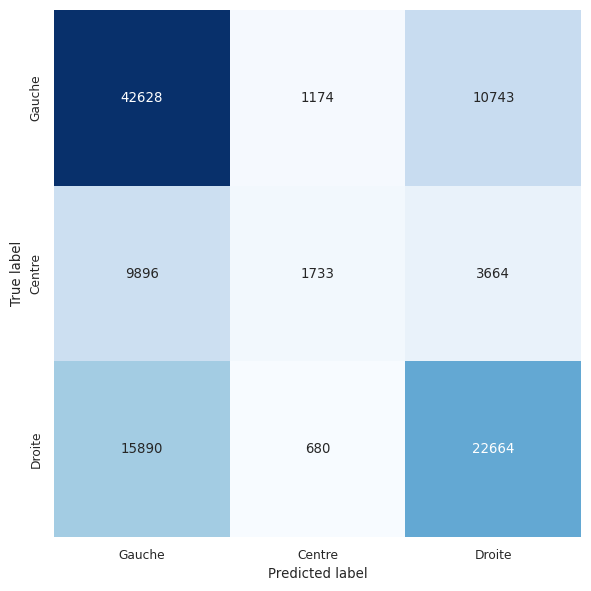

In [64]:
confusion_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized=None)
confusion_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix.png")

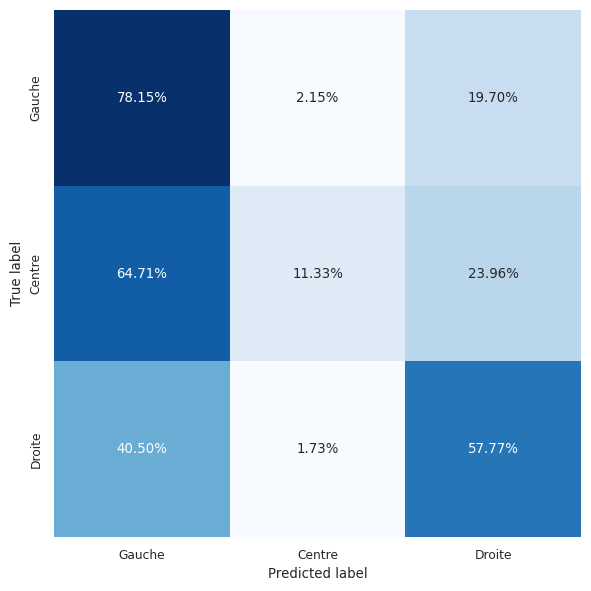

In [65]:
confusion_true_fig = plot_confusion_matrix(results, figsize=(6, 6), normalized="true")
confusion_true_fig.savefig(Path(RESULTS_PATH) / "confusion_matrix_true_normed.png")

Micro-averaged One-vs-Rest ROC AUC score:
0.81
Macro-averaged One-vs-Rest ROC AUC score:
0.76


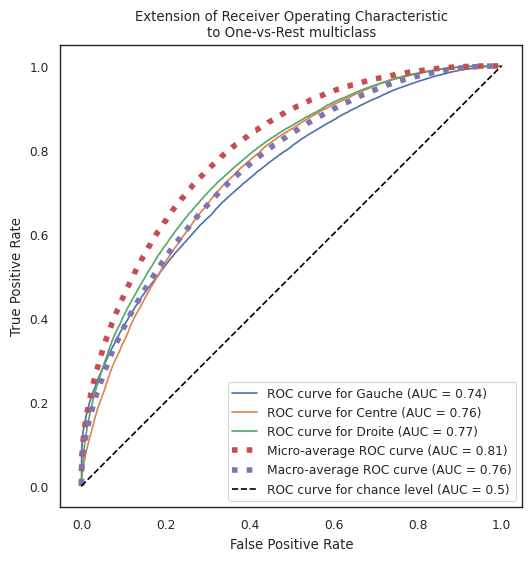

In [66]:
roc_fig = plot_roc_curve(results, figsize=(6, 6), palette="deep")
roc_fig.savefig(Path(RESULTS_PATH) / "roc_curve.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


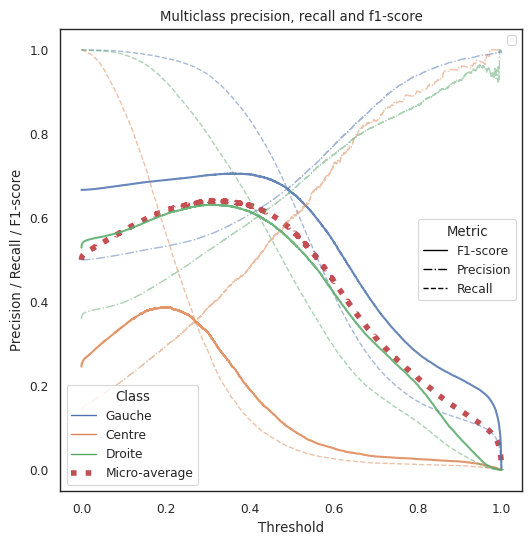

In [67]:
pr_fig = plot_precision_recall_curve(results, figsize=(6, 6), palette="deep")
pr_fig.savefig(Path(RESULTS_PATH) / "precision_recall_curve.png")

In [68]:
network_fig = plot_network_graph(NET, device=DEVICE, model_name=MODEL_NAME, path=RESULTS_PATH)